### Make sure some stuff are set up

1. Run `jupyter nbextension enable --py widgetsnbextension` to enable widgets

2. Install graphviz through ``brew`` or ``apt-get``

3. Install graphviz's Python binding:

    import sys
    !{sys.executable} -m pip install graphviz

### Import dependencies

In [105]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

from graphviz import Source

from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive

import ipywidgets as widgets

### How does the data look like?

NOTE: Trying to figure out which of the CSV files to use from the Kaggle dataset right now

According to the ProPublica description of their [data](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) they considered the following factors:
race, criminal history, future recidivism, charge degree, gender, and age.

They first did a logistic regression to test for racial disparities in results. They then ran a Cox proportional hazards model (which is what COMPAS's parent company did to assess the algorithm) to test the predictive accuracy of the COMPAS algorithm.  

Variables in the logistic regression included:
- each race category
- each age category
- number of priors
- misdimeanor
- two year recidivism 
- each age category (e.g. less than 25, greater than 45, etc)
- each sex category

In [29]:
# basic COMPAS scores CSV, with sex, race and just a few other useful predictors. not much to go on
# I don't think it makes much sense to use this one
compas_scores_raw_filename = 'data/compas-scores-raw.csv'
df_compas_raw = pd.read_csv(compas_scores_raw_filename)
df_compas_raw.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [30]:
df_compas_raw.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [3]:
# subset of ProPublica data focused on 'violent' offenders
# has much more information about cases than previous CSV file, we should use either this or the next one
violent_scores_filename = "data/cox-violent-parsed.csv"
df_compas_violent = pd.read_csv(violent_scores_filename)
df_compas_violent.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [4]:
df_compas_violent.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

In [5]:
# get number of columns
len(df_compas_violent.columns)

52

In [6]:
# this is a filtered down version of the previous CSV, with 12 fewer columns 
violent_scores_filt_filename = "data/cox-violent-parsed_filt.csv"
df_compas_violent_filt = pd.read_csv(violent_scores_filt_filename)
df_compas_violent_filt.head()

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [7]:
df_compas_violent_filt.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

In [9]:
# get number of columns
len(df_compas_violent_filt.columns)

40

In [10]:
set(df_compas_violent.columns) - set(df_compas_violent_filt.columns)

{'c_arrest_date',
 'c_case_number',
 'c_offense_date',
 'compas_screening_date',
 'end',
 'in_custody',
 'out_custody',
 'r_case_number',
 'r_jail_out',
 'start',
 'v_screening_date',
 'vr_case_number'}

### Let's select the features together?

In [159]:
# this is a filtered down version of the previous CSV, with 12 fewer columns 
violent_scores_filt_filename = "data/cox-violent-parsed_filt.csv"
df_compas_violent_filt = pd.read_csv(violent_scores_filt_filename)

In [160]:
target = 'score_text'
protected = 'race'

params = {col : False for col in set(df_compas_violent_filt.columns)- set([target, protected])}

In [161]:
df_selected = None


def clean_data(**params):
    global df_selected
    df_selected = df_compas_violent_filt.copy(deep=True) # Refresh raw data at every interaction
    
    dropped_cols = [k for k in params if not params[k]] # Features with unmarked check boxes
    
    df_selected.drop(dropped_cols, inplace=True, axis=1) # Switching off features by dropping them
    df_selected.dropna(inplace=True)
    
    return df_selected


inter1=interactive(clean_data, **params)
display(inter1)

interactive(children=(Checkbox(value=False, description='vr_offense_date'), Checkbox(value=False, description=…

In [162]:
df_selected.head()

,sex,age,age_cat,race,score_text
0,Male,69,Greater than 45,Other,Low
1,Male,69,Greater than 45,Other,Low
2,Male,31,25 - 45,Caucasian,Medium
3,Male,34,25 - 45,African-American,Low
4,Male,24,Less than 25,African-American,Low


In [163]:
# Should feature selection be done by the instructor using the interface?
selected_features = list(set(df_selected.columns) - set([target]))
cols_of_interest = selected_features + [target]
df_selected = pd.get_dummies(df_selected, columns=selected_features)

In [164]:
encoding = {'Low' : 0, 'Medium' : 1, 'High' : 2} # necessary to code variables for sklearn
df_selected[target] = df_selected[target].apply(lambda x: encoding[x])

In [165]:
df_selected.head()

,score_text,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,...,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1


### Cleaning the recidivism data

This is how ProPublica cleaned their data, and removed rows with missing data (copied from their notebook):

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility. (NOTE: *** I think this might be the `cox-violent-parsed_filt.csv` data we have?? double check)

They have a notebook with R code in it for this here: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb 

#### TODOs and things to figure out 
- I _think_ columns with a "c" prefix are the first charge, and those with an "r" prefix are the recidivist charge ("vr" is a violent recidivist charge)
- for data cleaning, definitely at least remove the rows with a -1 in the `is_recid` column
- I _think_ we should use the `cox-violent-parsed_filt.csv` data, but I want team confirmation!

### Let's see how a Decision Tree looks like?

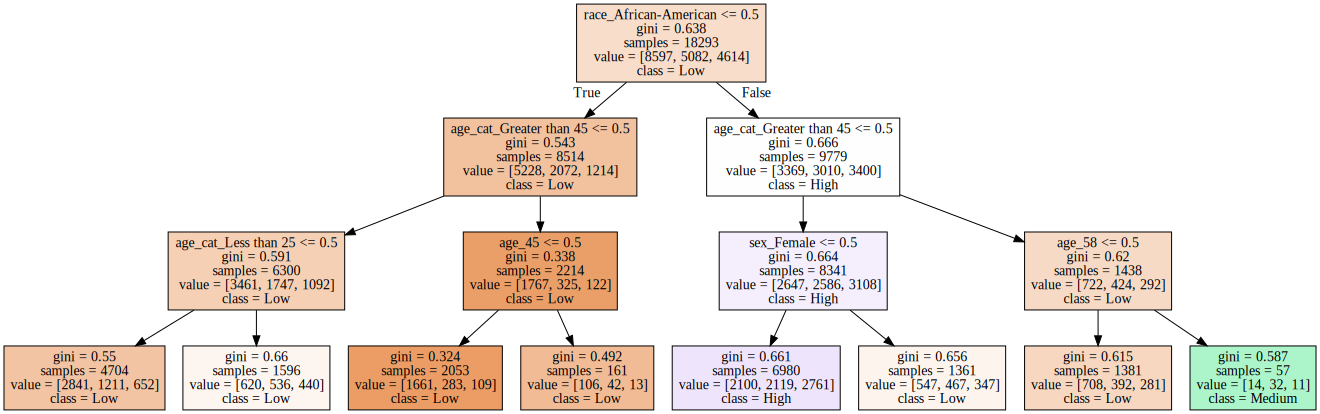

In [166]:
# Vanilla ML
X = df_selected[set(df_selected.columns) - set([target])]
Y = df_selected[target]
estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
estimator.fit(X, Y)

# Render Decision Tree
labels = X.columns
graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
display(SVG(graph.pipe(format='svg')))

### What happens if racial profiling skews the data even further?

In [169]:
protected_value = 'race_African-American'


# If a given row x (a training example) has 'racepctblack' greater than the median value, then
# multiply the outcome 'ViolentCrimesPerPop' by the user-defined ratio; otherwise, multiply by
# the inverse of the user-defined ratio.
# Interpretation: the greater the ratio, the worst is the bias against communities with above
# average Black populations; the smaller the ratio, the more favorable is the bias; setting to
# 1.0 keeps the data in its original form.

def apply_bias(x):
    global protected_value
    if (x[protected_value] and x[target] != 2):
        return x[target] + 1
    return x[target]


def plot_tree(racial_profiling=False):
    df_biased = df_selected.copy(deep=True)
    df_biased[target] = df_biased.apply(apply_bias, axis=1)
    
    # Vanilla ML
    X = df_biased[set(df_biased.columns) - set([target])]
    Y = df_biased[target]
    estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
    estimator.fit(X, Y)
    
    # Render Decision Tree
    labels = X.columns
    graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter2=interactive(plot_tree, racial_profiling=False)
display(inter2)

interactive(children=(Checkbox(value=False, description='racial_profiling'), Output()), _dom_classes=('widget-…